In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import random

# Cluster size feedback on SC

**The idea:** Implement an algorithm that drives an Ising model constructed on the Sierpinski carpet to self-organize at criticality.

**Steps:** 
1. Build a function that simulates the construction of the Sierpinski carpet and, according to it, create a lattice as a two-dimensional NumPy array with values of 0 if no spin is assigned, or 1 or -1 if a spin corresponds.
2. Implement the Metropolis algorithm with $m$ iterations and the Swendsen-Wang algorithm with $n$ iterations to reach equilibrium at an initial temperature.
3. Save the last configuration of clusters provided by the Swendsen-Wang algorithm.
4. Check if any of those clusters is infinite. If so, increase the temperature by a $dT$. Otherwise, decrease the temperature by a $dT$.
5. Repeat steps 2, 3, and 4 with this new temperature until the algorithm converges.

In [2]:
def sierpinski_carpet(mask, total): #total number of times the process will be repeated  
    for i in range(0, total + 1):
        stepdown = 3**(total - i)
        for x in range(0, 3**i):
          
            # checking for the centremost square
            if x % 3 == 1:
                for y in range(0, 3**i):
                    if y % 3 == 1:
                      
                    # changing its value
                        mask[y * stepdown:(y + 1)*stepdown, x * stepdown:(x + 1)*stepdown] = 0
                        
    return mask

In [3]:
def flattice(times):#total number of times the process will be repeated

    N= 3**times # size of the lattice
    lattice= np.ones((N,N))
    flattice= sierpinski_carpet(lattice, times)
    init_random = np.random.random((N,N))
    random_filter = sierpinski_carpet(init_random, times)
    flattice= flattice.copy()
    mask1= random_filter>=0.5 
    flattice[mask1] = 1
    mask2 = (random_filter<0.5) & (random_filter!= 0)
    flattice[mask2] = -1
    
    return flattice

In [4]:
#Auxiliar function for metropolis algorithm
def calculate_energy(lattice, i, j):
    size = lattice.shape[0]
    
    spin_ij = lattice[i, j]

    neighbors_indices = [((i+1) % size, j), ((i-1+size) % size, j), (i, (j+1) % size), (i, (j-1+size) % size)]


    dE = 0

    for ni, nj in neighbors_indices:
        if 0 <= ni < size and 0 <= nj < size:
            spin_neighbor = lattice[ni, nj]
            dE += 2 * spin_ij * spin_neighbor

    return dE

In [5]:
def metropolis_step(lattice, temperature):
    
    size = lattice.shape[0]
    i, j = random.randint(0, size-1), random.randint(0, size-1)
    
    beta= 1/temperature
    
    while lattice[i,j] == 0:
        i, j = random.randint(0, size-1), random.randint(0, size-1)
        
    dE = calculate_energy(lattice, i, j)
    
    if (dE > 0) and (np.random.random() < np.exp(-dE*beta)):
        lattice[i, j] *= -1
    elif dE <= 0:
        lattice[i, j] *= -1

In [6]:
def swendsen_wang_step(lattice, times, temperature, r_clusters):
    
    size = lattice.shape[0]
    
    visited = np.full_like(lattice, -1)
    
    visited = sierpinski_carpet(visited, times)
        
    clusters = []
    
    # Calculate bond probability based on temperature and coupling constant J

    p = 1.0 - np.exp(-2 /(temperature))

    for i in range(size):
        for j in range(size):
            if visited[i, j] == -1:
                cluster = set()
                stack = [(i, j)]

                while stack:
                    x, y = stack.pop()
                    if visited[x, y] == -1:
                        visited[x, y] = 1
                        cluster.add((x, y))
                        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                            nx, ny = x + dx, y + dy  
                            if 0 <= nx < size and 0 <= ny < size: 
                                if visited[nx, ny] == -1 and lattice[x, y] == lattice[nx, ny] and np.random.rand() < p:
                                    stack.append((nx, ny))

                clusters.append(cluster)
    
    for cluster in clusters:
        if random.random() < 0.5:
            for i, j in cluster:
                lattice[i, j] *= -1
                
    if r_clusters == True:  
        return clusters

In [7]:
def combined_metropolis_swendsen_wang(lattice, temperature, times,  m, n):
    for _ in range(m):
        metropolis_step(lattice, temperature)
    for _ in range(n):
        swendsen_wang_step(lattice, times, temperature, False)

In [8]:
def is_infinite_cluster(cluster, times):
    
    min_x = min(coord[0] for coord in cluster)
    max_x = max(coord[0] for coord in cluster)
    min_y = min(coord[1] for coord in cluster)
    max_y = max(coord[1] for coord in cluster)
    

    grid_size = 3**times
    
    if (min_x == 0 and max_x == grid_size - 1) or (min_y == 0 and max_y == grid_size - 1):
        return True
    else:
        return False

In [9]:
def feedback(clusters, dTJ, times):
    i=0
    while i < len(clusters):
        is_infinite = is_infinite_cluster(clusters[i], times)
        if is_infinite == True:
            deltaTJ= dTJ
            break
        else:
            i+=1
            deltaTJ= -dTJ
            
    return deltaTJ

In [10]:
def get_spin_energy_fb(lattice, times):
    
    steps= 90
    
    ms = np.zeros(steps)
    number_clusters= np.zeros(steps)
    mean_size_cluster= np.zeros(steps)
    tjs= np.zeros(steps)

    TJ= TJf_
    
    m= 100000
    n= 200
    
    for i in tqdm (range(steps), desc="Implementing feedback"):
        combined_metropolis_swendsen_wang(lattice, TJ, times, m, n)
        clusters= swendsen_wang_step(lattice, times, TJ, True)
        ms[i] = lattice.sum()/np.count_nonzero(lattice)
        number_clusters[i]= len(clusters)
        mean_size_cluster[i]= (sum(len(cluster) for cluster in clusters))/len(clusters)
        TJ= TJ+ feedback(clusters, dTJ, times)
        tjs[i]= TJ
    return ms, tjs, number_clusters, mean_size_cluster

First, initialize the algorithm at a temperature below the critical temperature, $T_i = 1.0$. In this case, we will use a lattice with $L = 3^5$. It's important to emphasize that the larger the lattice, the greater the precision in converging to the critical temperature.

In [11]:
dTJ= 0.01
TJf_=1.0
lattice= flattice(5)


bjf_=[]
ms_=[]
nc_=[]
msc_=[]

ms, bjf, nc, msc= get_spin_energy_fb(lattice, 5)
bjf_.append(bjf)
ms_.append(ms)
nc_.append(nc)
msc_.append(msc)

Implementing feedback: 100%|██████████| 90/90 [52:56<00:00, 35.29s/it]


In [12]:
bjf_

[array([1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11,
        1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22,
        1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33,
        1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44,
        1.45, 1.46, 1.47, 1.46, 1.45, 1.46, 1.47, 1.48, 1.47, 1.46, 1.45,
        1.46, 1.45, 1.44, 1.43, 1.44, 1.45, 1.46, 1.47, 1.46, 1.45, 1.44,
        1.45, 1.46, 1.45, 1.46, 1.47, 1.46, 1.47, 1.46, 1.45, 1.46, 1.45,
        1.46, 1.45, 1.44, 1.45, 1.46, 1.47, 1.46, 1.45, 1.46, 1.45, 1.46,
        1.45, 1.46])]

Now, initialize the algorithm at a temperature above the critical temperature, $T_i=2.0$.

In [13]:
lattice= flattice(5)
dTJ= 0.01
TJf_=2.0

bjf2_=[]
ms2_=[]
nc2_=[]
msc2_=[]

ms, bjf, nc, msc= get_spin_energy_fb(lattice, 5)
bjf2_.append(bjf)
ms2_.append(ms)
nc2_.append(nc)
msc2_.append(msc)

Implementing feedback: 100%|██████████| 90/90 [53:43<00:00, 35.81s/it]


In [14]:
bjf2_

[array([1.99, 1.98, 1.97, 1.96, 1.95, 1.94, 1.93, 1.92, 1.91, 1.9 , 1.89,
        1.88, 1.87, 1.86, 1.85, 1.84, 1.83, 1.82, 1.81, 1.8 , 1.79, 1.78,
        1.77, 1.76, 1.75, 1.74, 1.73, 1.72, 1.71, 1.7 , 1.69, 1.68, 1.67,
        1.66, 1.65, 1.64, 1.63, 1.62, 1.61, 1.6 , 1.59, 1.58, 1.57, 1.56,
        1.55, 1.54, 1.53, 1.52, 1.51, 1.5 , 1.49, 1.48, 1.47, 1.46, 1.47,
        1.46, 1.47, 1.46, 1.45, 1.46, 1.45, 1.44, 1.45, 1.46, 1.47, 1.46,
        1.45, 1.46, 1.45, 1.46, 1.47, 1.48, 1.47, 1.48, 1.47, 1.48, 1.47,
        1.46, 1.45, 1.46, 1.45, 1.44, 1.43, 1.44, 1.43, 1.44, 1.43, 1.44,
        1.45, 1.46])]

## Convergence to critical temperature

Text(0.5, 0, 'Iterative step')

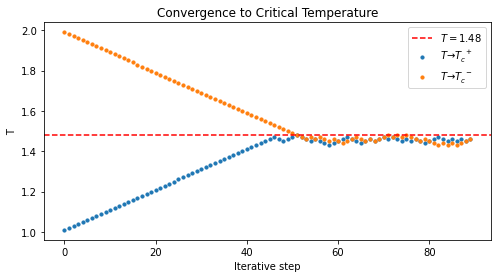

In [15]:
x= np.arange(90)
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.scatter(x, bjf_, s=10, label= r"$T \to T_c^{~+}$")
plt.scatter(x, bjf2_, s=10, label= r"$T \to T_c^{~-}$")
plt.title(r"Convergence to Critical Temperature")
plt.axhline(y=1.48, color='red', linestyle='--', label=r'$T=1.48$')
plt.ylabel(r'T')
plt.legend()
plt.xlabel('Iterative step')

## Number of clusters

In [16]:
ts= np.array(bjf_.copy())
ts2= np.array(bjf2_.copy())
ts=abs(ts- 1.48)
ts2=abs(ts2 -1.48)

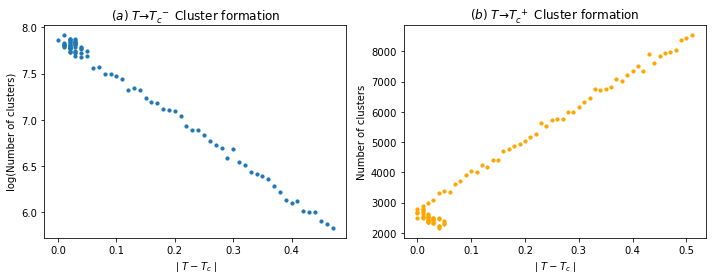

In [17]:
plt.figure(figsize=(10, 4))  
plt.subplot(1, 2, 1) 
plt.scatter(ts, np.log(nc_), s=10)
plt.title(r"$(a) ~T \to T_c^{~-}$ Cluster formation")
plt.ylabel('log(Number of clusters)')
plt.xlabel('$\mid T - T_c \mid$')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.scatter(ts2, nc2_, color= "orange", s=10)
plt.title(r"$(b)~ T \to T_c^{~+}$ Cluster formation")
plt.ylabel("Number of clusters")
plt.xlabel('$\mid T - T_c \mid$')

plt.tight_layout() 